In [1]:
import scanpy as sc
import numpy as np
import mudi as md

/home/sanand/anaconda3/envs/renv/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


### Rudimentary Cell-type Calling

Using differentially expressed genes & overlap to reference set.

In [2]:
adata = sc.datasets.pbmc3k()

In [3]:
adata = md.recipe(
    adata,
    min_genes=200,
    min_cells=3,
    thresh=1.75,
    mito_thresh=None,
    verbose=True,
    norm='scran'
)

	Filtering louvain group 8 - percent_mito < 0.043241834500804543
	Filtering louvain group 3 - percent_mito < 0.047272084979340434
	Filtering louvain group 1 - percent_mito < 0.04667235352098942
	Filtering louvain group 2 - percent_mito < 0.03154836967587471
	Filtering louvain group 0 - percent_mito < 0.03964273538440466
	Filtering louvain group 6 - percent_mito < 0.039234081748872995
	Filtering louvain group 5 - percent_mito < 0.055335435550659895
	Filtering louvain group 4 - percent_mito < 0.03999753319658339
	Filtering louvain group 7 - percent_mito < 0.029138509882614017
Filtered 114 / 2700 barcodes by percent_mito.


... storing 'batch' as categorical
... storing 'phase' as categorical


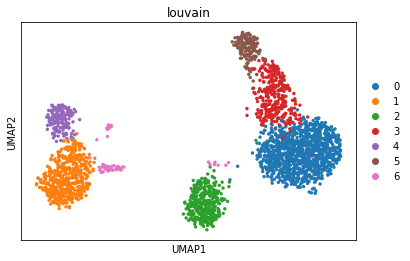

In [4]:
sc.pl.umap(adata, color=['louvain'])

### Here are the Immune Markers We Have

In [5]:
md.ref.IMMUNE_MARKERS

{'tcell_activated': ['CD69', 'IL2RA'],
 'tcell_effector': ['CD3D', 'B3GAT1', 'PDCD1', 'FAS', 'CCR7'],
 'tcell_regulatory': ['CD4',
  'IL2RA',
  'FOXP3',
  'SMAD3',
  'STAT5A',
  'STAT5B',
  'IL10'],
 'tcell_exhausted': ['CD3D',
  'PDCD1',
  'FAS',
  'CCR7',
  'SELL',
  'LAG3',
  'HAVCR2',
  'TIGIT',
  'ENTPD1'],
 'tcell_helper_1': ['CD4', 'CXCR3', 'TBX21', 'STAT1', 'STAT6', 'IFNG'],
 'tcell_helper_2': ['CD4',
  'CCR4',
  'PTGDR2',
  'GATA3',
  'STAT5',
  'STAT6',
  'IL4',
  'IL5',
  'IL13'],
 'tcell_naive': ['IL7R', 'S100A4', 'CD3D', 'SELL', 'CD27'],
 'tcell_cytotoxic': ['CD8A', 'CD8B'],
 'tcell_memory': ['IL7R', 'CD3D', 'CCR7', 'SELL'],
 'tcell_helper_17': ['CD4', 'CCR6', 'RORC', 'RORA', 'STAT3', 'IL17A', 'IL17F'],
 'bcell_activated': ['CD19', 'IL2RA', 'CD30'],
 'bcell_plasma': ['CD27', 'CD38', 'SDC1', 'SLAMF7', 'IL6'],
 'bcell_memory': ['MS4A1',
  'CD27',
  'CD40',
  'CD80',
  'PDCD1LG2',
  'CXCR3',
  'CXCR4',
  'CXCR5',
  'CXCR6'],
 'bcell_marginal': ['CD1A', 'CR2', 'CD37', 'NOTCH2'

#### Convert these to a pd.DataFrame

`mudi` has a helper: `mudi.convert_marker_dict_to_df`

In [6]:
markers_df = md.convert_marker_dict_to_df(md.ref.IMMUNE_MARKERS)
markers_df.head()

,Cell-Type,Gene
0,tcell_activated,CD69
1,tcell_activated,IL2RA
2,tcell_effector,CD3D
3,tcell_effector,B3GAT1
4,tcell_effector,PDCD1


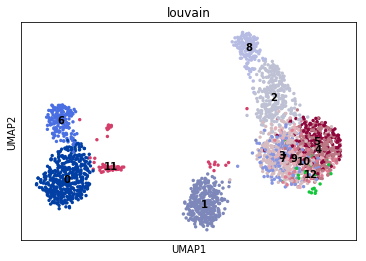

In [7]:
sc.tl.louvain(adata, resolution=2)
sc.pl.umap(adata, color='louvain', legend_loc='on data')

In [8]:
scores, aggr, labels = md.build_marker_set(
    adata, 
    markers_df, 
    groupby='louvain', 
    thresh=1e-2, 
    metric='sum'
)

... storing 'cell_type' as categorical


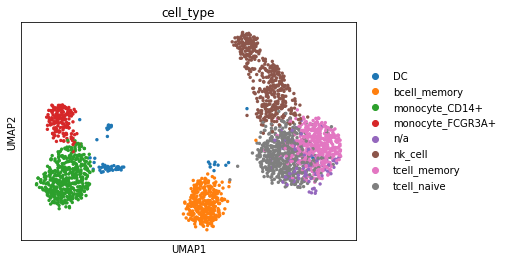

In [9]:
sc.pl.umap(adata, color=['cell_type'])

I have a hunch that my markers for cytotoxic t-cells are not able to overcome the NK signal. Thus, I manually tweak the `nk_cell` class.

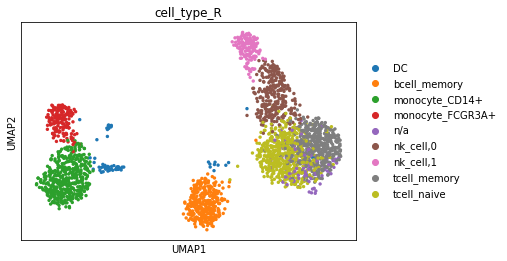

... storing 'cell_type_R' as categorical


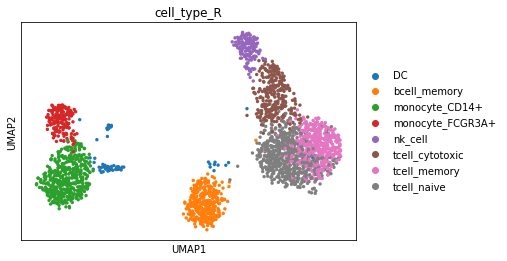

In [10]:
gene_labels_df = md.sub_cluster_and_rename(
    adata, 
    'cell_type', 
    ['nk_cell'], 
    markers_df, 
    res=0.5, 
    tweaks={"nk_cell,0":"tcell_cytotoxic"}
)

In [11]:
# Data frame with genes used for labeling
gene_labels_df.head()

,cluster,no.,names,scores,pvals,pvals_adj,logfoldchanges,cell_type,label
2,DC,2,FCER1A,7.124157,1.151662e-09,2.632316e-06,7.406236,DC,DC
202,monocyte_CD14+,2,LYZ,61.458172,1.197327e-269,5.473382e-266,6.194794,DC,monocyte_CD14+
153,bcell_memory,53,CD19,8.917334,2.708498e-17,3.376758e-15,5.385762,bcell_activated,bcell_memory
120,bcell_memory,20,FCER2,13.432439,2.382928e-33,9.336993e-31,6.628574,bcell_follicular,bcell_memory
160,bcell_memory,60,CD22,8.671155,1.222263e-16,1.373944e-14,4.041298,bcell_follicular,bcell_memory
